# Imports

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import ta

from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
from pprint import pprint

import gc
import optuna
from sklearn.feature_selection import RFE


/tmp/ipykernel_439/384002432.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('Data/pair_features1_300_60.csv')
df.head()

,Date,Ticker_P1,Close_P1,Ticker_P2,Close_P2,High_P1,High_P2,Low_P1,Low_P2,Volume_P1,...,abs_spread_normed_max,abs_spread_normed_90th,abs_spread_normed_75th,abs_spread_normed_median,abs_spread_normed_l7_avg,abs_spread_normed_l14_avg,cos_sim,corr_coef,pnls,num_entries
0,2015-01-02,CAG,21.161,NOC,126.094,28.241,149.160,27.868,144.540,5126379.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-05,CAG,20.931,NOC,123.433,28.023,146.470,27.564,142.450,5400213.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-06,CAG,20.724,NOC,124.114,27.743,146.000,27.167,141.580,5229051.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-07,CAG,21.214,NOC,128.040,27.977,148.830,27.432,144.880,3124092.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-08,CAG,21.675,NOC,131.010,28.560,153.140,28.054,149.810,4154019.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df['pnls'] = df['pnls']*100.0

In [4]:
total_days = df.Date.nunique()
total_days

1257

In [5]:
df.dropna()

,Date,Ticker_P1,Close_P1,Ticker_P2,Close_P2,High_P1,High_P2,Low_P1,Low_P2,Volume_P1,...,abs_spread_normed_max,abs_spread_normed_90th,abs_spread_normed_75th,abs_spread_normed_median,abs_spread_normed_l7_avg,abs_spread_normed_l14_avg,cos_sim,corr_coef,pnls,num_entries
598,2017-05-18,CAG,30.320,NOC,220.839,37.910,248.990,37.550,243.390,1873300.000,...,2.976,2.271,1.896,1.527,1.576,1.587,0.999,0.807,8.484,1.000
599,2017-05-19,CAG,30.353,NOC,223.522,37.920,250.380,37.550,247.600,2315700.000,...,2.976,2.271,1.896,1.534,1.586,1.607,0.999,0.804,8.542,1.000
600,2017-05-22,CAG,30.626,NOC,223.137,38.140,254.000,37.650,249.410,2596500.000,...,2.976,2.271,1.896,1.541,1.594,1.618,0.999,0.802,-7.606,1.000
601,2017-05-23,CAG,30.884,NOC,224.211,38.600,251.450,38.030,248.580,2263200.000,...,2.976,2.271,1.896,1.541,1.611,1.632,0.999,0.800,-7.463,1.000
602,2017-05-24,CAG,31.012,NOC,226.653,38.720,253.580,38.500,251.000,1837100.000,...,2.976,2.271,1.896,1.541,1.648,1.657,0.999,0.797,7.843,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256935,2019-09-27,TEL,85.735,MAS,38.672,93.980,41.820,92.470,41.100,638600.000,...,2.163,1.720,1.386,0.863,0.768,0.938,0.999,0.879,0.000,0.000
1256936,2019-09-30,TEL,86.170,MAS,38.672,93.810,41.980,92.950,41.340,1156800.000,...,2.163,1.720,1.386,0.863,0.705,0.905,0.999,0.879,0.000,0.000
1256937,2019-10-01,TEL,84.644,MAS,38.988,94.280,43.160,91.500,42.010,1172600.000,...,2.163,1.720,1.386,0.863,0.601,0.846,0.999,0.879,0.000,0.000
1256938,2019-10-02,TEL,82.314,MAS,37.958,91.260,41.750,88.350,40.470,1380800.000,...,2.163,1.720,1.386,0.863,0.535,0.765,0.999,0.879,0.000,0.000


In [6]:
df = df.sort_values('Date')

In [7]:
print(df.Date.min(),df.Date.max())

2015-01-02 2019-12-30


## Technical Indicators

In [8]:
class feature_engineering(object):
    def __init__(self):
        super(feature_engineering, self).__init__()

    def generate_technical_indicator(self, data_df): 
        '''
        Function to generate additional technical indicators for the stock

        Uses the "statsmodels.tsa.stattools" (as "ts") package to apply 
        the equations specified in the "Technical Indicators" markdown section 
        to stock closing data.
        
        Input:
        data_df-- Dataframe containing stock finacials data
        
        Output:
        Stock finacials data with added Dataframe of feature obtained from feature engineering
        ''' 
        # 1. Momentum Indicators
        # Relative Strength Index
        df = data_df
#         df['rsi'] = ta.momentum.rsi(df['Close'], window=14)
#         # Kaufman’s Adaptive Moving Average (KAMA)
#         df['kama'] = ta.momentum.kama(df['Close'],window=14)

#         # 2. Volume Indicators
#         # Accumulation/Distribution Index (ADI)
#         df['adi'] = ta.volume.acc_dist_index(df['High'], df['Low'], df['Close'], df['Volume'])

#         # Volume-price trend (VPT)
#         df['vpt'] = ta.volume.volume_price_trend(df['Close'], df['Volume'])

#         # 3. Volatility Indicators
#         # Average True Range (ATR)
#         df['atr'] = ta.volatility.average_true_range(df['High'], df['Low'],df['Close'], window=14)

#         # Bollinger Bands (BB) N-period simple moving average (MA)
#         df['bb_ma'] = ta.volatility.bollinger_mavg(df['Close'], window=20)

#         # 4. Trend Indicators
#         # Average Directional Movement Index (ADX)
#         df['adx'] = ta.trend.adx(df['High'], df['Low'], df['Close'], window=14)

#         # Exponential Moving Average
#         df['ema'] = ta.trend.ema_indicator(df['Close'], window=14)

#         # Moving Average Convergence Divergence (MACD)
#         df['macd'] = ta.trend.macd(df['Close'], window_fast=14, window_slow=30)

#         # 5. Other Indicators
#         # Daily Log Return (DLR)
#         df['dlr'] = ta.others.daily_log_return(df['Close'])

#         # Daily Returns
#         df['daily_returns'] = df['Close'].pct_change()

#         # Moving Averages
#         averages = [50,200]
#         for avg in averages:
#             col_name = str(avg) +' Days Average'
#             df[col_name] = df['Close'].rolling(window = avg, center = False).mean()

        return df

### Load SPY

In [9]:
spy_df = pd.read_csv('Data/1999-12-01-2023-12-31_SPY.csv')
spy_df = spy_df[['Date','Adj Close']]
spy_df.columns = ['Date','SPY_Close']
df = pd.merge(df,spy_df,on='Date',how='left')

In [10]:
# del spy_df
# gc.collect()

In [11]:
df = df.dropna()
df

,Date,Ticker_P1,Close_P1,Ticker_P2,Close_P2,High_P1,High_P2,Low_P1,Low_P2,Volume_P1,...,abs_spread_normed_90th,abs_spread_normed_75th,abs_spread_normed_median,abs_spread_normed_l7_avg,abs_spread_normed_l14_avg,cos_sim,corr_coef,pnls,num_entries,SPY_Close
598000,2017-05-18,NOC,220.839,VRTX,117.930,248.990,118.610,243.390,115.420,1033600.000,...,2.143,1.675,1.321,0.247,0.276,0.993,0.353,0.000,0.000,210.962
598001,2017-05-18,CAG,30.320,DLTR,79.000,37.910,79.450,37.550,77.830,1873300.000,...,2.011,1.633,0.867,0.377,0.289,0.993,-0.323,0.000,0.000,210.962
598002,2017-05-18,NOC,220.839,GIS,44.200,248.990,56.160,243.390,55.750,1033600.000,...,2.240,1.889,1.620,1.656,1.671,0.994,-0.351,3.545,1.000,210.962
598003,2017-05-18,NOC,220.839,UPS,82.969,248.990,103.640,243.390,102.120,1033600.000,...,2.252,1.912,1.597,1.795,1.758,0.998,0.565,-0.572,1.000,210.962
598004,2017-05-18,CAG,30.320,CB,121.314,37.910,139.900,37.550,137.570,1873300.000,...,1.985,1.797,1.425,2.025,2.043,1.000,0.884,-6.867,1.000,210.962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196995,2019-10-03,CAG,23.895,PPG,105.900,28.350,114.610,27.530,112.020,5761300.000,...,1.946,1.630,1.126,0.988,1.114,0.987,0.069,7.625,1.000,271.375
1196996,2019-10-03,NOC,338.671,T,19.705,364.990,28.097,359.250,27.689,835600.000,...,2.397,1.925,1.009,2.044,2.135,0.999,0.931,-5.167,1.000,271.375
1196997,2019-10-03,CAG,23.895,GPN,154.164,28.350,158.780,27.530,153.780,5761300.000,...,2.627,2.394,1.877,1.108,1.230,0.974,-0.041,9.289,1.000,271.375
1196998,2019-10-03,NOC,338.671,APH,45.329,364.990,47.320,359.250,46.300,835600.000,...,2.456,1.917,1.058,2.042,2.141,0.993,0.262,9.285,1.000,271.375


### Beta

In [12]:
def compute_beta(rs,df,ticker,market):
    rows = df.loc[rs.index]
    sec_returns = np.log( df[[ticker,market]] / df[[ticker,market]].shift(1) ) 

    cov = sec_returns.cov() * 250
    cov_with_market = cov.iloc[0,1]
    market_var = sec_returns[market].var() * 250
    beta = cov_with_market / market_var
    return beta

In [13]:
all_tickers = df['Ticker_P1'].unique().tolist()+df['Ticker_P2'].unique().tolist()
len(all_tickers)

478

In [14]:
fe_obj = feature_engineering()

### Single Ticker Features

In [15]:
df.columns

Index(['Date', 'Ticker_P1', 'Close_P1', 'Ticker_P2', 'Close_P2', 'High_P1',
       'High_P2', 'Low_P1', 'Low_P2', 'Volume_P1', 'Volume_P2', 'abs_spread',
       'abs_spread_mean', 'abs_spread_std', 'abs_spread_mean_l28',
       'abs_spread_std_l28', 'spread_normed', 'abs_spread_normed_max',
       'abs_spread_normed_90th', 'abs_spread_normed_75th',
       'abs_spread_normed_median', 'abs_spread_normed_l7_avg',
       'abs_spread_normed_l14_avg', 'cos_sim', 'corr_coef', 'pnls',
       'num_entries', 'SPY_Close'],
      dtype='object')

In [16]:
df.sort_values('Date')

,Date,Ticker_P1,Close_P1,Ticker_P2,Close_P2,High_P1,High_P2,Low_P1,Low_P2,Volume_P1,...,abs_spread_normed_90th,abs_spread_normed_75th,abs_spread_normed_median,abs_spread_normed_l7_avg,abs_spread_normed_l14_avg,cos_sim,corr_coef,pnls,num_entries,SPY_Close
598000,2017-05-18,NOC,220.839,VRTX,117.930,248.990,118.610,243.390,115.420,1033600.000,...,2.143,1.675,1.321,0.247,0.276,0.993,0.353,0.000,0.000,210.962
598658,2017-05-18,CAG,30.320,NEE,28.926,37.910,34.432,37.550,33.930,1873300.000,...,2.040,1.470,0.859,1.544,1.393,0.999,0.613,0.000,0.000,210.962
598659,2017-05-18,CAG,30.320,LUV,53.832,37.910,57.780,37.550,56.960,1873300.000,...,1.934,1.394,1.037,2.043,2.126,0.994,0.769,-0.406,1.000,210.962
598660,2017-05-18,CAG,30.320,EFX,126.358,37.910,136.250,37.550,133.490,1873300.000,...,2.464,1.966,1.350,1.241,1.327,0.998,0.413,-5.578,1.000,210.962
598661,2017-05-18,NOC,220.839,MO,44.004,248.990,70.850,243.390,70.270,1033600.000,...,2.411,1.956,1.486,1.465,1.475,0.999,0.741,9.241,1.000,210.962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196338,2019-10-03,NOC,338.671,LUV,50.477,364.990,52.440,359.250,51.260,835600.000,...,2.389,1.800,0.972,2.085,2.153,0.991,0.154,-3.530,1.000,271.375
1196339,2019-10-03,CAG,23.895,OXY,40.120,28.350,43.400,27.530,42.260,5761300.000,...,2.331,1.825,1.060,1.737,1.713,0.984,0.390,0.000,0.000,271.375
1196340,2019-10-03,NOC,338.671,RMD,125.398,364.990,130.530,359.250,127.400,835600.000,...,2.301,1.862,0.999,1.945,2.008,0.998,0.829,-12.177,1.000,271.375
1196327,2019-10-03,CAG,23.895,INTC,44.347,28.350,50.070,27.530,48.530,5761300.000,...,2.527,1.602,0.539,0.320,0.378,0.982,-0.285,10.017,1.000,271.375


In [17]:
all_tickers_df_list = []
for t in tqdm(all_tickers):
    single_ticker_df = (df[df['Ticker_P1']==t] if t in df['Ticker_P1'].unique() else df[df['Ticker_P2']==t])
    single_ticker_df = single_ticker_df.sort_values('Date')
    single_ticker_df = single_ticker_df[['Date','Ticker_P1','Close_P1','High_P1','Low_P1','Volume_P1','SPY_Close']] if t in df['Ticker_P1'].unique() else\
                       single_ticker_df[['Date','Ticker_P2','Close_P2','High_P2','Low_P2','Volume_P2','SPY_Close']]
    single_ticker_df.columns = ['Date','Ticker','Close','High','Low','Volume','SPY_Close']
    single_ticker_df = single_ticker_df.drop_duplicates()
    single_ticker_df = single_ticker_df.dropna()

#     single_ticker_df['rolling_beta'] = single_ticker_df['Close'].rolling(300).progress_apply(compute_beta, \
#                                         args=(single_ticker_df,'Close','SPY_Close'))

    single_ticker_df_with_technical_indicators = fe_obj.generate_technical_indicator(single_ticker_df)
    



    
    all_tickers_df_list.append(single_ticker_df_with_technical_indicators)


  0%|          | 0/478 [00:00<?, ?it/s]

In [18]:
all_tickers_df = pd.concat(all_tickers_df_list,axis=0,ignore_index=True).reset_index(drop=True)
all_tickers_df.shape

(286322, 7)

In [19]:
df = df.reset_index(drop=True)

In [20]:
df.tail(2)

,Date,Ticker_P1,Close_P1,Ticker_P2,Close_P2,High_P1,High_P2,Low_P1,Low_P2,Volume_P1,...,abs_spread_normed_90th,abs_spread_normed_75th,abs_spread_normed_median,abs_spread_normed_l7_avg,abs_spread_normed_l14_avg,cos_sim,corr_coef,pnls,num_entries,SPY_Close
598998,2019-10-03,NOC,338.671,APH,45.329,364.990,47.320,359.250,46.300,835600.000,...,2.456,1.917,1.058,2.042,2.141,0.993,0.262,9.285,1.000,271.375
598999,2019-10-03,CAG,23.895,TYL,262.070,28.350,262.990,27.530,255.450,5761300.000,...,1.984,1.548,0.655,1.927,1.930,0.989,0.440,-2.552,1.000,271.375


In [21]:
all_tickers_df.head(100)

,Date,Ticker,Close,High,Low,Volume,SPY_Close
0,2017-05-18,NOC,220.839,248.990,243.390,1033600.000,210.962
1,2017-05-19,NOC,223.522,250.380,247.600,716900.000,212.334
2,2017-05-22,NOC,223.137,254.000,249.410,1062600.000,213.412
3,2017-05-23,NOC,224.211,251.450,248.580,801400.000,213.885
4,2017-05-24,NOC,226.653,253.580,251.000,775000.000,214.383
...,...,...,...,...,...,...,...
95,2017-10-03,NOC,262.354,292.320,289.020,576800.000,227.520
96,2017-10-04,NOC,263.345,292.610,290.210,572200.000,227.790
97,2017-10-05,NOC,263.796,293.220,290.960,540500.000,229.140
98,2017-10-06,NOC,264.382,293.380,291.850,382000.000,228.879


In [22]:
# print(df.shape)
# all_tickers_df_P1_suffix = all_tickers_df.copy()
# all_tickers_df_P1_suffix.columns = ['Date','Ticker']+[c+'_P1' for c in all_tickers_df.columns if c not in ['Date','Ticker']]
# all_tickers_df_P2_suffix = all_tickers_df.copy()
# all_tickers_df_P2_suffix.columns = ['Date','Ticker']+[c+'_P2' for c in all_tickers_df.columns if c not in ['Date','Ticker']]

# df = pd.merge(df,all_tickers_df_P1_suffix,left_on=['Date','Ticker_P1'],right_on=['Date','Ticker'],\
#               how='left',suffixes=['','_P1']).drop_duplicates()
# print(df.shape)
# df = pd.merge(df,all_tickers_df_P2_suffix,left_on=['Date','Ticker_P2'],right_on=['Date','Ticker'],\
#               how='left',suffixes=['','_P2']).drop_duplicates()
# print(df.shape)
# df = df.loc[:,~df.columns.duplicated()]
# print(df.shape)


In [23]:
# del all_tickers_df_P1_suffix, all_tickers_df_P2_suffix
# gc.collect()

In [24]:
# df = df.drop('Ticker',axis=1)

## Add group based features

### Merge Sector

In [25]:
# sector_df = pd.read_csv('Data/1999-12-01-2023-12-31.csv')
# sector_df = sector_df.drop_duplicates(subset=['Ticker','GICS Sector'])[['Ticker','GICS Sector']]
# sector_df

In [26]:
# industry_df = pd.read_csv('Data/1999-12-01-2023-12-31.csv')
# industry_df = industry_df.drop_duplicates(subset=['Ticker','GICS Sub-Industry'])[['Ticker','GICS Sub-Industry']]
# industry_df

In [27]:
# df = pd.merge(df,sector_df.rename(columns={'GICS Sector':'Sector_P1'}),how='left',left_on='Ticker_P1',right_on='Ticker').drop('Ticker',axis=1)
# df = pd.merge(df,sector_df.rename(columns={'GICS Sector':'Sector_P2'}),how='left',left_on='Ticker_P2',right_on='Ticker').drop('Ticker',axis=1)
# df = pd.merge(df,industry_df.rename(columns={'GICS Sub-Industry':'Industry_P1'}),how='left',left_on='Ticker_P1',right_on='Ticker').drop('Ticker',axis=1)
# df = pd.merge(df,industry_df.rename(columns={'GICS Sub-Industry':'Industry_P2'}),how='left',left_on='Ticker_P2',right_on='Ticker').drop('Ticker',axis=1)

In [28]:
# del sector_df
# del industry_df
# gc.collect()

### Prev Values

In [29]:
# df = df.sort_values('Date')

In [30]:
# df['PREV_num_entries'] = df.groupby(['Ticker_P1','Ticker_P2']).num_entries.shift(61)
# df['PREV_pnls'] = df.groupby(['Ticker_P1','Ticker_P2']).pnls.shift(61)

# Trim head and tail days

In [31]:
# print(df.shape)
# df = df.drop(df.groupby(['Ticker_P1','Ticker_P2']).head(301).index,axis=0)
# print(df.shape)
# df = df.drop(df.groupby(['Ticker_P1','Ticker_P2']).tail(61).index,axis=0)
# print(df.shape)


### Sector

In [32]:
# all_sectors = df['Sector_P1'].unique().tolist()+df['Sector_P2'].unique().tolist()
# len(all_sectors)

In [33]:
# all_sectors_df_list = []
# for s in tqdm(all_sectors):
#     single_sector_df = (df[df['Sector_P1']==s] if s in df['Sector_P1'].unique() else df[df['Sector_P2']==s])
#     single_sector_df = single_sector_df.sort_values('Date')

#     single_sector_df = single_sector_df[['Date','Sector_P1','daily_returns_P1','rolling_beta_P1']] if s in df['Sector_P1'].unique() else\
#                        single_sector_df[['Date','Sector_P2','daily_returns_P2','rolling_beta_P2']]
#     single_sector_df.columns = ['Date','Sector','daily_returns','rolling_beta']
#     single_sector_df = single_sector_df.drop_duplicates()

#     single_sector_df['sector_rolling_beta_mean'] = single_sector_df.groupby('Date').rolling_beta.transform(np.nanmean)
#     single_sector_df['sector_rolling_beta_std'] = single_sector_df.groupby('Date').rolling_beta.transform(np.nanstd)
#     single_sector_df['sector_daily_return_mean'] = single_sector_df.groupby('Date').daily_returns.transform(np.nanmean)
#     single_sector_df['sector_daily_return_std'] = single_sector_df.groupby('Date').daily_returns.transform(np.nanstd)

#     all_sectors_df_list.append(single_sector_df)


In [34]:
# all_sectors_df = pd.concat(all_sectors_df_list,axis=0,ignore_index=True).reset_index(drop=True)
# all_sectors_df.tail(2)

In [35]:
# stop

In [36]:
# print(df.shape)
# all_sectors_df = all_sectors_df.drop(['daily_returns','rolling_beta'],axis=1).drop_duplicates()
# all_sectors_df_P1_suffix = all_sectors_df.copy()
# all_sectors_df_P1_suffix.columns = ['Date','Sector']+[c+'_P1' for c in all_sectors_df.columns if c not in ['Date','Sector']]
# all_sectors_df_P2_suffix = all_sectors_df.copy()
# all_sectors_df_P2_suffix.columns = ['Date','Sector']+[c+'_P2' for c in all_sectors_df.columns if c not in ['Date','Sector']]

# df = pd.merge(df,all_sectors_df_P1_suffix,left_on=['Date','Sector_P1'],right_on=['Date','Sector'],\
#               how='left',suffixes=['','_P1']).drop_duplicates()
# print(df.shape)
# df = pd.merge(df,all_sectors_df_P2_suffix,left_on=['Date','Sector_P2'],right_on=['Date','Sector'],\
#               how='left',suffixes=['','_P2']).drop_duplicates()
# print(df.shape)
# df = df.loc[:,~df.columns.duplicated()]
# print(df.shape)

In [37]:
# del all_sectors_df_P1_suffix, all_sectors_df_P2_suffix
# gc.collect()

### Diff Values

In [38]:
# for c in ['Close', 'High', 'Low', 'Volume', 'rolling_beta', 'rsi', 'kama',
#        'adi', 'vpt', 'atr', 'bb_ma', 'adx', 'ema', 'macd', 'dlr',
#        'daily_returns', '50 Days Average', '200 Days Average']:
# # ,
# #        'sector_rolling_beta_mean', 'sector_rolling_beta_std',
# #        'sector_daily_return_mean', 'sector_daily_return_std']:
#     df['DIFF_'+c] = df[c+'_P1'] - df[c+'_P2']

In [39]:
# df['DIFF_abs_spread_mean_l28_500'] = df['abs_spread_mean_l28'] - df['abs_spread_mean']

In [40]:
# df.isna().sum().sort_values(ascending=False).head(20)

In [41]:
# stop

# Classification to predict PNL_IS_0

In [42]:
# categorical_features = ['Sector_P1','Sector_P2','Industry_P1','Industry_P2']
categorical_features = []

In [43]:
# for c in categorical_features:
#     df[c] = df[c].astype('category')

In [44]:
# df.head()

## X,y split

In [45]:
# df['PNL_IS_0'] = np.where(df.pnls==0,1,0)

In [46]:
# df.columns

In [47]:
# features = df.drop(categorical_features+['PNL_IS_0']+\
#                    ['abs_spread_normed_max','abs_spread_normed_median',\
#                     'abs_spread_normed_75th','abs_spread_normed_90th',\
#                     'Date','Ticker_P1','Ticker_P2','SPY_Close_P1','SPY_Close_P2',\
#                     'num_entries','pnls']+[c for c in df.columns if '_P1_P1' in c or '_P2_P2' in c],axis=1).columns.tolist()+categorical_features
# label = 'PNL_IS_0'

features = df.columns

label = 'pnls'

In [48]:
print(df.shape)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna(subset=features)
print(df.shape)


(599000, 28)
(599000, 28)


In [49]:
print(df.Date.min(),df.Date.max())

2017-05-18 2019-10-03


In [50]:
X = df[features]
y = df[label]

X = X.drop(['Date', 'Ticker_P1', 'Ticker_P2'],axis=1)

In [51]:
X

,Close_P1,Close_P2,High_P1,High_P2,Low_P1,Low_P2,Volume_P1,Volume_P2,abs_spread,abs_spread_mean,...,abs_spread_normed_90th,abs_spread_normed_75th,abs_spread_normed_median,abs_spread_normed_l7_avg,abs_spread_normed_l14_avg,cos_sim,corr_coef,pnls,num_entries,SPY_Close
0,220.839,117.930,248.990,118.610,243.390,115.420,1033600.000,2154800.000,102.909,109.356,...,2.143,1.675,1.321,0.247,0.276,0.993,0.353,0.000,0.000,210.962
1,30.320,79.000,37.910,79.450,37.550,77.830,1873300.000,1856300.000,48.680,52.977,...,2.011,1.633,0.867,0.377,0.289,0.993,-0.323,0.000,0.000,210.962
2,220.839,44.200,248.990,56.160,243.390,55.750,1033600.000,3304400.000,176.639,150.718,...,2.240,1.889,1.620,1.656,1.671,0.994,-0.351,3.545,1.000,210.962
3,220.839,82.969,248.990,103.640,243.390,102.120,1033600.000,2890800.000,137.870,114.560,...,2.252,1.912,1.597,1.795,1.758,0.998,0.565,-0.572,1.000,210.962
4,30.320,121.314,37.910,139.900,37.550,137.570,1873300.000,1798200.000,90.993,81.733,...,1.985,1.797,1.425,2.025,2.043,1.000,0.884,-6.867,1.000,210.962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598995,23.895,105.900,28.350,114.610,27.530,112.020,5761300.000,674600.000,82.005,75.932,...,1.946,1.630,1.126,0.988,1.114,0.987,0.069,7.625,1.000,271.375
598996,338.671,19.705,364.990,28.097,359.250,27.689,835600.000,26973322.000,318.966,261.091,...,2.397,1.925,1.009,2.044,2.135,0.999,0.931,-5.167,1.000,271.375
598997,23.895,154.164,28.350,158.780,27.530,153.780,5761300.000,1904100.000,130.268,105.512,...,2.627,2.394,1.877,1.108,1.230,0.974,-0.041,9.289,1.000,271.375
598998,338.671,45.329,364.990,47.320,359.250,46.300,835600.000,1762800.000,293.342,233.943,...,2.456,1.917,1.058,2.042,2.141,0.993,0.262,9.285,1.000,271.375


## Train test split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42,shuffle=False)

In [53]:
print(df.loc[X_val.index].Date.min(),df.loc[X_val.index].Date.max())

2019-04-15 2019-07-11


In [54]:
# print(X_train.shape)
# print(X_val.shape)
# print(X_test.shape)

In [55]:
# y_train.value_counts()

In [56]:
# y_val.value_counts()

In [57]:
# y_test.value_counts()

In [58]:
# undersample = RandomUnderSampler(sampling_strategy='majority')
# X_train, y_train = undersample.fit_resample(X_train, y_train)

## Logistic Regression

In [59]:
# scaler = StandardScaler().fit(X_train.drop(categorical_features,axis=1))
# scaled_X_train = scaler.transform(X_train.drop(categorical_features,axis=1))
# scaled_X_val = scaler.transform(X_val.drop(categorical_features,axis=1))
# scaled_X_test = scaler.transform(X_test.drop(categorical_features,axis=1))

In [60]:
# y.value_counts()

In [61]:
# clf = LogisticRegression()

# # Train the model using the training sets
# clf.fit(scaled_X_train, y_train)

# # Make predictions using the testing set
# lr_preds = clf.predict(scaled_X_test)

In [62]:
# print(f1_score(y_test, lr_preds, average='weighted'))
# print(f1_score(y_test, lr_preds, average='micro'))
# print(f1_score(y_test, lr_preds, average='macro'))

## Confusion Matrix

In [63]:
# cm = confusion_matrix(y_test, lr_preds, labels=clf.classes_,normalize='true')

In [64]:
# 26955/(26955+5781)

In [65]:
# 63650/(63650+8719)

In [66]:
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
# disp.plot()

## Feature Importance

In [67]:
# pi = permutation_importance(clf,scaled_X_test,y_test)

# coefs = pd.DataFrame(
#     pi['importances_mean'], columns=["Coefficients"], index=X_train.drop(categorical_features,axis=1).columns
# )

# coefs.plot(kind="barh", figsize=(20, 7))
# plt.title("Logistic Regression model")
# plt.axvline(x=0, color=".5")
# plt.subplots_adjust(left=0.3)

## GBM

### Optuna

In [68]:
# def objective(trial):
#     params = {
#         'boosting':'dart',
#         "objective": "binary",
# #         "metric": "accuracy",
#         'class_weight':'balanced',
#         "n_estimators": 300,
#         "verbosity": -1,
#         "bagging_freq": 1,
#         'max_bin':trial.suggest_int('max_bin',64,1024),
#         'max_depth':trial.suggest_int('max_depth',4,20),

#         "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 3000),
#         "subsample": trial.suggest_float("subsample", 0.05, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 1000),
#     }

#     model = lgb.LGBMClassifier(**params)
#     model.fit(X_train.drop(categorical_features,axis=1),y_train)
#     predictions = model.predict(X_val.drop(categorical_features,axis=1))
#     f1 = f1_score(y_val, predictions, average='weighted')
#     return -1*f1

In [69]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=30)

In [70]:
# print('Best hyperparameters:', study.best_params)
# print('Best F1:', study.best_value*(-1))

In [71]:
# hyper_params = study.best_params

In [72]:
# y_train.value_counts()/len(y_train)

In [73]:
# gbm = lgb.LGBMClassifier(**hyper_params)
# callbacks = [\
# #             lgb.early_stopping(stopping_rounds=10, verbose=1,min_delta=0.001,first_metric_only=False), 
#              lgb.log_evaluation(period=1)]

# gbm.fit(X_train.drop(categorical_features,axis=1),y_train, 
#         eval_set=[(X_val.drop(categorical_features,axis=1), y_val)],
#         eval_metric='accuracy',
#         callbacks=callbacks,
#         feature_name = [f for f in features if f not in categorical_features],
# #         categorical_feature=categorical_features
#        )

In [74]:
# gbm_preds = gbm.predict(X_test.drop(categorical_features,axis=1))

In [75]:
# print(f1_score(y_test, gbm_preds, average='weighted'))
# print(f1_score(y_test, gbm_preds, average='micro'))
# print(f1_score(y_test, gbm_preds, average='macro'))

In [76]:
# cm = confusion_matrix(y_test, gbm_preds, labels=gbm.classes_,normalize='true')
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gbm.classes_)
# disp.plot()

In [77]:
# importances = gbm.feature_importances_
# importances = pd.Series(importances,index=X_train.drop(categorical_features,axis=1).columns).sort_values(ascending=True)

In [78]:
# fig,ax=plt.subplots(figsize=[16,14])
# importances.plot.barh(ax=ax)
# ax.set_title("Feature Importance by Gain")
# fig.tight_layout()

In [79]:
# STOP

# Regression

## Remove 0s?

In [80]:
# df[df.pnls==0].shape[0]*100.0/df.shape[0]

In [81]:
# df = df[df.pnls!=0]


## X,y split

In [82]:
# features = df.drop(categorical_features+['PNL_IS_0']+\
#                    ['abs_spread_normed_max','abs_spread_normed_median',\
#                     'abs_spread_normed_75th','abs_spread_normed_90th',\
#                     'Date','Ticker_P1','Ticker_P2','SPY_Close_P1','SPY_Close_P2',\
#                     'num_entries','pnls']+[c for c in df.columns if '_P1_P1' in c or '_P2_P2' in c],axis=1).columns.tolist()+categorical_features
# label = 'pnls'


In [83]:
# X = df[features]
# y = df[label]

# X = X.drop(['Date', 'Ticker_P1', 'Ticker_P2', 'pnls'],axis=1)

In [84]:
# y = pd.Series(np.where(y.abs()<=3.5,0,np.where(y<0,-1,1)))

In [85]:
# y.value_counts()

## Train test split

In [86]:
# y.abs().describe(np.arange(0,1,0.1))

In [87]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42,shuffle=False)

### Filter Outliers?

In [88]:
u = np.mean(y_train)
s = np.std(y_train)
y_train = y_train[(y_train>(u-2*s)) & (y_train<(u+2*s))]
X_train = X_train.loc[y_train.index]

In [89]:
# undersample = RandomUnderSampler(sampling_strategy='not minority')
# X_train, y_train = undersample.fit_resample(X_train, y_train)

In [90]:
# y_train.value_counts()

In [91]:
# y_val.value_counts()

In [92]:
# y_test.value_counts()

## GBM

In [93]:
# def objective(trial):
#     params = {
#         'boosting':'dart',
#         "objective": "multiclass",
# #         'device':'gpu',
# #         "metric": "accuracy",
# #         'class_weight':'balanced',
#         "n_estimators": 300,
#         "verbosity": -1,
#         "bagging_freq": 1,
#         'max_bin':trial.suggest_int('max_bin',64,1024),
#         'max_depth':trial.suggest_int('max_depth',4,20),

#         "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 3000),
#         "subsample": trial.suggest_float("subsample", 0.05, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 1000),
#     }

#     model = lgb.LGBMClassifier(**params)
#     model.fit(X_train.drop(categorical_features,axis=1),y_train)
#     predictions = model.predict(X_val.drop(categorical_features,axis=1))
#     f1 = f1_score(y_val, predictions, average='weighted')
#     return -1*f1

In [94]:
# def objective(trial):
#     params = {
#         'boosting':'dart',
#         "objective": "mse",
# #         'device':'gpu',
#         "metric": 'l1',
# #         'class_weight':'balanced',
#         "n_estimators": 300,
#         "verbosity": -1,
# #         "bagging_freq": 1,
#         'max_bin':trial.suggest_int('max_bin',64,1024),
#         'max_depth':trial.suggest_int('max_depth',4,20),

#         "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 3000),
#         "subsample": trial.suggest_float("subsample", 0.05, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 1000),
#     }

#     model = lgb.LGBMRegressor(**params)
#     model.fit(X_train.drop(categorical_features,axis=1),y_train)
#     predictions = model.predict(X_val.drop(categorical_features,axis=1))
#     mae = np.mean(abs(predictions-y_val))
#     return mae

In [95]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=2)

In [96]:
# df[[c for c in features if c not in categorical_features]+[label]].corr()['pnls'].abs().sort_values(ascending=False).head(10)

In [97]:
# print('Best hyperparameters:', study.best_params)
# print('Best mae:', study.best_value)

In [98]:
# hyper_params = study.best_params

In [99]:
# hyper_params = {
# #     'task': 'train',
#     'boosting_type': 'gbdt',
#     'objective': 'mae',
#     'metric': ['l1'],
# #     'eval_metric': ['l1'],
# #     'early_stopping_rounds':10,
#     'learning_rate': 0.2,
# #     'feature_fraction': 0.9,
# #     'bagging_fraction': 0.7,
# #     'bagging_freq': 10,
#     'verbosity': 1,
# #     "max_depth": 8,
# #     "num_leaves": 128,  
# #     "max_bin": 512,
#     "num_iterations": 200,
#     "importance_type":"gain"
    
# #     "silent":False
# }

In [100]:
# gbm = lgb.LGBMRegressor(**hyper_params)
# # gbm = lgb.LGBMClassifier(**hyper_params)

# callbacks = [\
# #             lgb.early_stopping(stopping_rounds=10, verbose=1,min_delta=0.001,first_metric_only=False), 
#              lgb.log_evaluation(period=1)]

# gbm.fit(X_train.drop(categorical_features,axis=1),y_train, 
#         eval_set=[(X_val.drop(categorical_features,axis=1), y_val )],
# #         eval_metric='l1',
#         callbacks=callbacks,
# #         feature_name = features,
# #         categorical_feature=categorical_features
#        )

In [101]:
# preds = gbm.predict(X_test.drop(categorical_features,axis=1))
# cm = confusion_matrix(y_test, preds, labels=gbm.classes_,normalize='true')
# cm

In [102]:
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gbm.classes_)
# disp.plot()

### GBM feature importance

In [103]:
# importances = gbm.feature_importances_
# importances = pd.Series(importances,index=X_train.drop(categorical_features,axis=1).columns).sort_values(ascending=True)

In [104]:
# fig,ax=plt.subplots(figsize=[16,14])
# importances.plot.barh(ax=ax)
# ax.set_title("Feature Importance by Gain")
# fig.tight_layout()

In [105]:
# pi = permutation_importance(gbm,X_test.drop(categorical_features,axis=1),y_test)

# coefs = pd.DataFrame(
#     pi['importances_mean'], columns=["Coefficients"], index=X_train.drop(categorical_features,axis=1).columns
# )
# coefs.plot(kind="barh", figsize=(9, 7))
# plt.title("Logistic Regression model")
# plt.axvline(x=0, color=".5")
# plt.subplots_adjust(left=0.3)

## Error Analysis

In [106]:
# preds = gbm.predict(X_test.drop(categorical_features,axis=1))

In [107]:
# results = pd.DataFrame({'preds':preds,'true':y_test})
# results

In [108]:
# results.describe(np.arange(0,1,0.1))

In [109]:
# mae = (preds-y_test).abs().mean()
# mae

In [110]:
# mean_abs_label = y_test.abs().mean()
# mean_abs_label

In [111]:
# mae/mean_abs_label

In [112]:
# mae_AR1 = (X_test.PREV_pnls - pnl_not_0.true).abs().mean()
# mae_AR1

In [113]:
# mae/mae_AR1

## Linear Regression

In [114]:
# features = df.drop(categorical_features+['PNL_IS_0']+\
#                    ['abs_spread_normed_max','abs_spread_normed_median',\
#                     'abs_spread_normed_75th','abs_spread_normed_90th',\
#                     'Date','Ticker_P1','Ticker_P2','SPY_Close_P1','SPY_Close_P2',\
#                     'num_entries','pnls']+[c for c in df.columns if '_P1_P1' in c or '_P2_P2' in c],axis=1).columns.tolist()+categorical_features
# label = 'pnls'

In [115]:
# X = df[features]
# y = df[label]

# X = X.drop(['Date', 'Ticker_P1', 'Ticker_P2', 'pnls'],axis=1)

In [116]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42,shuffle=False)

In [117]:
# categorical_features = []
# scaler = StandardScaler().fit(X_train.drop(categorical_features,axis=1))
# scaled_X_train = scaler.transform(X_train.drop(categorical_features,axis=1))
# scaled_X_val = scaler.transform(X_val.drop(categorical_features,axis=1))
# scaled_X_test = scaler.transform(X_test.drop(categorical_features,axis=1))

scaled_X_train = X_train
scaled_X_val = X_val
scaled_X_test = X_test

In [118]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout
#Creating the LSTM model
class lstm(Model):
    def __init__(self, in_shape, look_back):
        super(lstm, self).__init__()
        self.shape = in_shape
        self.look_back = look_back
        self.lstm_l1 = LSTM(256, input_shape=self.shape, return_sequences = True)
#         self.lstm_l2 = LSTM(256)
        self.dropout = Dropout(0.2)
        self.dense = Dense(self.look_back)

    def call(self, x):
        x = self.lstm_l1(x)
#         x = self.lstm_l2(x)
        x = self.dropout(x)
        x = self.dense(x)
        return x

2024-03-06 05:59:40.701280: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-06 05:59:42.124031: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [119]:
# Reshape X for model training
trainX = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
valX = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
testX = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [120]:
#initializing the lstm model
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3,\
                                            min_delta=0.001,restore_best_weights=True,verbose=1)

lstm_model = lstm((trainX.shape[1], trainX.shape[2]), look_back = 1)
lstm_model.compile(loss='mae', 
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), metrics=['mae'])
#fitting the model
history = lstm_model.fit(
                    trainX, 
                    y_train, 
                    epochs=20, 
                    batch_size=32,
                    validation_data=(valX, y_val), 
                    verbose=1, 
                    callbacks=callback,
                    shuffle=True)

Epoch 1/20


2024-03-06 05:59:43.904574: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


13900/13900 [==============================] - 60s 4ms/step - loss: 2.1931 - mae: 2.1931 - val_loss: 2.9890 - val_mae: 2.9890
Epoch 2/20
13900/13900 [==============================] - 58s 4ms/step - loss: 2.1906 - mae: 2.1906 - val_loss: 2.9907 - val_mae: 2.9907
Epoch 3/20
13900/13900 [==============================] - 58s 4ms/step - loss: 2.1904 - mae: 2.1904 - val_loss: 2.9873 - val_mae: 2.9873
Epoch 4/20
13900/13900 [==============================] - 59s 4ms/step - loss: 2.1906 - mae: 2.1906 - val_loss: 2.9889 - val_mae: 2.9889
Epoch 5/20
13900/13900 [==============================] - 59s 4ms/step - loss: 2.1906 - mae: 2.1906 - val_loss: 2.9892 - val_mae: 2.9892
Epoch 6/20
13900/13900 [==============================] - 59s 4ms/step - loss: 2.1905 - mae: 2.1905 - val_loss: 2.9898 - val_mae: 2.9898
Epoch 6: early stopping


In [138]:
lstm_model.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               multiple                  288768    
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  257       
                                                                 
Total params: 289025 (1.10 MB)
Trainable params: 289025 (1.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


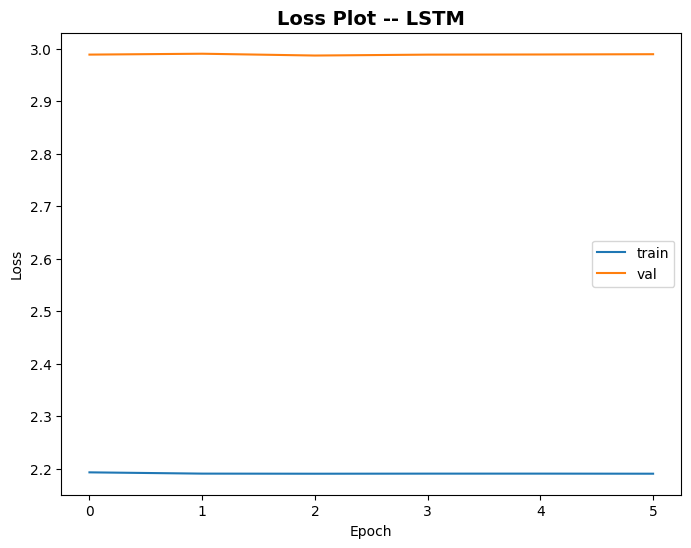

In [139]:
# Plot line graph to show amount loss according the the epoch
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss Plot -- LSTM', fontsize=14, color="black", fontweight="bold")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [140]:
lstm_mae = (lstm_model.predict(testX).flatten() - y_test).abs().mean()
lstm_mae

1872/1872 [==============================] - 2s 1ms/step


3.9777209071247475

In [141]:
mean_abs_label = y_test.abs().mean()
mean_abs_label

lstm_mae / mean_abs_label

1.000065586157352

In [125]:
# regr = LinearRegression()

# # Train the model using the training sets
# regr.fit(scaled_X_train, y_train)

# # Make predictions using the testing set
# lr_preds = regr.predict(scaled_X_test)

In [126]:
# pi = permutation_importance(regr,scaled_X_test,y_test)

# coefs = pd.DataFrame(
#     pi['importances_mean'], columns=["Coefficients"], index=X_train.drop(categorical_features,axis=1).columns
# )


# coefs.plot(kind="barh", figsize=(9, 7))
# plt.title("LR model")
# plt.axvline(x=0, color=".5")
# plt.subplots_adjust(left=0.3)

In [127]:
# lr_results = pd.DataFrame({'preds':lr_preds,'true':y_test})
# lr_results

In [128]:
# lr_pnl_is_0 = lr_results[lr_results.true==0]
# lr_pnl_not_0 = lr_results[lr_results.true!=0]

In [129]:
# mae = (lr_pnl_not_0.preds-lr_pnl_not_0.true).abs().mean()

In [130]:
# mae/mean_abs_label

In [131]:
# lr_results.loc[tmp_df.index]

In [132]:
# from sklearn.ensemble import RandomForestRegressor

In [133]:
# rf = RandomForestRegressor(verbose=2,n_jobs=-1)

In [134]:
# rf.fit(X_train.drop(categorical_features,axis=1),y_train)

In [135]:
# preds = rf.predict(X_test.drop(categorical_features,axis=1))

In [136]:
# mae = (preds-y_test).abs().mean()
# mae

In [137]:
# mae/mean_abs_label